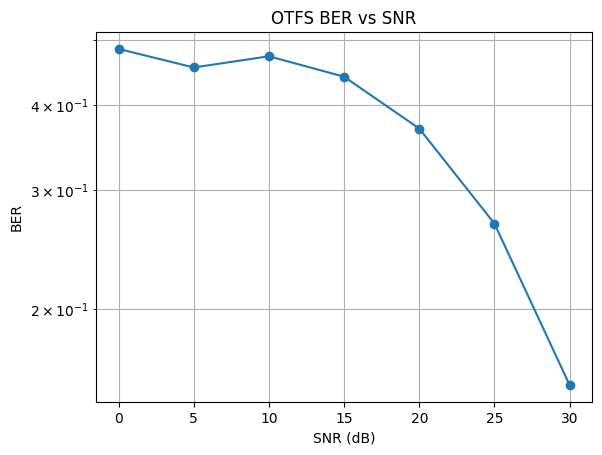

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.special import erfc

def helperOTFSmod(data_mod, M, N):
    # Reshape data correctly before applying OTFS modulation
    data_reshaped = data_mod[:M * N].reshape(N, M)
    return np.fft.ifft2(data_reshaped)

def helperOTFSdemod(rx_signal, M, N):
    # OTFS demodulation
    return np.fft.fft2(rx_signal).flatten()

# System parameters
M = 64  # Number of subcarriers
N = 30  # Number of symbols per frame
SNRdB_range = np.arange(0, 35, 5)  # SNR range in dB

# Generate data symbols
data = np.random.randint(0, 2, M * N)  # Ensure correct size

data_mod = (2 * data - 1) + 1j * (2 * np.random.randint(0, 2, M * N) - 1)  # QPSK modulation

# OTFS modulation
tx_signal = helperOTFSmod(data_mod, M, N)

# Channel model (example with simple delay and Doppler)
channel_response = np.ones_like(tx_signal)  # Placeholder for actual channel response
rx_signal = tx_signal * channel_response

# Add AWGN at different SNRs
BER = []

for SNRdB in SNRdB_range:
    SNR = 10**(SNRdB / 10)
    noise = (np.random.randn(*rx_signal.shape) + 1j * np.random.randn(*rx_signal.shape)) * np.sqrt(1 / (2 * SNR))
    rx_signal_noisy = rx_signal + noise
    
    # OTFS demodulation
    demod_data = helperOTFSdemod(rx_signal_noisy, M, N)
    
    # Calculate BER
    demod_bits = (np.real(demod_data) > 0).astype(int)
    bit_errors = np.sum(data != demod_bits[:len(data)])
    BER.append(bit_errors / len(data))

# Plot BER vs SNR
plt.figure()
plt.semilogy(SNRdB_range, BER, 'o-')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.title('OTFS BER vs SNR')
plt.grid(True, which='both')
plt.show()